In [1]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

Files already downloaded and verified


# Basic Usage

Top predictions for crab:


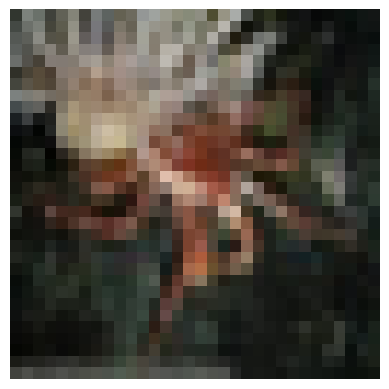


Top predictions:

            crab: 21.90%
          spider: 19.63%
   aquarium_fish: 8.58%
       pine_tree: 5.29%
       palm_tree: 4.59%


In [3]:
# Randomly pick an image from the dataset
image, class_id = cifar100[100]
image_input = preprocess(image).unsqueeze(0).to(device)
# token
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)
# Plot the image
print(f"Top predictions for {cifar100.classes[class_id]}:")
plt.imshow(image)
plt.axis('off')
plt.show()
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

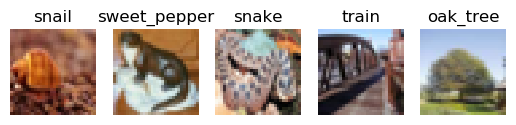

In [4]:
# token
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
# Randomly pick 5 images from the dataset
fig, axs = plt.subplots(1, 5)
for i in range(5):
    image, class_id = cifar100[np.random.randint(0, 10000)]
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    axs[i].imshow(image)
    axs[i].set_title(f"{cifar100.classes[indices[0]]}")
    axs[i].axis('off')
plt.show()

# Use Features to Train a Model

In [5]:
# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [02:47<00:00,  1.68s/it]
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+05    |proj g|=  7.66204D+02

At iterate   50    f=  3.36941D+04    |proj g|=  2.94516D+02

At iterate  100    f=  2.93115D+04    |proj g|=  1.77418D+02

At iterate  150    f=  2.83540D+04    |proj g|=  1.66042D+02

At iterate  200    f=  2.81607D+04    |proj g|=  4.33953D+01

At iterate  250    f=  2.81312D+04    |proj g|=  3.65381D+01

At iterate  300    f=  2.81225D+04    |proj g|=  1.01251D+01

At iterate  350    f=  2.81195D+04    |proj g|=  1.23092D+01

At iterate  400    f=  2.81174D+04    |proj g|=  3.63604D+00

At iterate  450    f=  2.81137D+04    |proj g|=  1.83754D+01

At iterate  500    f=  2.81012D+04    |proj g|=  1.02228D+01

At iterate  550    f=  2.80900D+04    |proj g|=  1.54301D+01

At iterate  600    f=  2.80856D+04    |proj g|=  4.80076D+00

At iterate  650    f=  2.8

KeyboardInterrupt: 

In [6]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+05    |proj g|=  7.66204D+02


 This problem is unconstrained.



At iterate   50    f=  3.36941D+04    |proj g|=  2.94516D+02

At iterate  100    f=  2.93115D+04    |proj g|=  1.77418D+02

At iterate  150    f=  2.83540D+04    |proj g|=  1.66042D+02

At iterate  200    f=  2.81607D+04    |proj g|=  4.33953D+01

At iterate  250    f=  2.81312D+04    |proj g|=  3.65381D+01

At iterate  300    f=  2.81225D+04    |proj g|=  1.01251D+01

At iterate  350    f=  2.81195D+04    |proj g|=  1.23092D+01

At iterate  400    f=  2.81174D+04    |proj g|=  3.63604D+00

At iterate  450    f=  2.81137D+04    |proj g|=  1.83754D+01

At iterate  500    f=  2.81012D+04    |proj g|=  1.02228D+01

At iterate  550    f=  2.80900D+04    |proj g|=  1.54301D+01

At iterate  600    f=  2.80856D+04    |proj g|=  4.80076D+00

At iterate  650    f=  2.80848D+04    |proj g|=  8.48634D+00

At iterate  700    f=  2.80846D+04    |proj g|=  1.59170D+00

At iterate  750    f=  2.80845D+04    |proj g|=  3.32838D+00

At iterate  800    f=  2.80843D+04    |proj g|=  6.36514D+00

At iter

KeyboardInterrupt: 